# Final Project - Amazone Book Recommendor System




# **1. Introduction**

The objective is to optimize Amazon’s book recommender system to drive higher revenue by delivering personalized and accurate recommendations. Leveraging Amazon’s known data on books' users, examination history, and basic demographic information. To improve Amazon’s books recommender system, the proposed hybrid solution integrates the following techniques:

For new uses: 
- Popularity Based Recommender : Recommend books based on the overall popularity trends
- Demographic Analysis: Improves personalization using users’ attributes such as age and location.

For current users:
- Collaborative Filtering : An advanced developed recently that captures static user preferences through interaction similarity scoring
- Compare user-based and item-based Collabrative Filtering

# **2. Assumptions and Data Exploration**
## **2.1 Assumptions**
Amazon can have access to:
- User Interaction Data: Rating and review history.
- Book Metadata: Titles, genres, authors, publishers, pricing, and availability.
- Demographic Data: Users' age group, location (e.g., city or country).

In [2]:
# Import Libraries
import pandas as pd
import sys
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import random

import warnings
warnings.filterwarnings('ignore')

import scipy
import math
import sklearn

!pip install nltk
from nltk.corpus import stopwords
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from scipy.sparse.linalg import svds
import matplotlib.pyplot as plt

from sklearn.neighbors import NearestNeighbors
from scipy.spatial.distance import correlation
from sklearn.metrics.pairwise import pairwise_distances
import ipywidgets as widgets
from IPython.display import display, clear_output
from contextlib import contextmanager
from sklearn.metrics.pairwise import cosine_similarity
from scipy.sparse.linalg import svds

import os, sys
import re
from scipy.sparse import csr_matrix

Defaulting to user installation because normal site-packages is not writeable


#### Dataset Loading

In [3]:
# Load Dataset
user=pd.read_csv("data/Users.csv")
book=pd.read_csv("data/Books.csv")
rating=pd.read_csv("data/Ratings.csv")

#### Display the dataset

In [4]:
# User Dataset 
user.head()

,User-ID,Location,Age
0,1,"nyc, new york, usa",NaN
1,2,"stockton, california, usa",18.0
2,3,"moscow, yukon territory, russia",NaN
3,4,"porto, v.n.gaia, portugal",17.0
4,5,"farnborough, hants, united kingdom",NaN


In [5]:
# Book Dataset 
book.head()

,ISBN,Book-Title,Book-Author,Year-Of-Publication,Publisher,Image-URL-S,Image-URL-M,Image-URL-L
0,0195153448,Classical Mythology,Mark P. O. Morford,2002,Oxford University Press,http://images.amazon.com/images/P/0195153448.0...,http://images.amazon.com/images/P/0195153448.0...,http://images.amazon.com/images/P/0195153448.0...
1,0002005018,Clara Callan,Richard Bruce Wright,2001,HarperFlamingo Canada,http://images.amazon.com/images/P/0002005018.0...,http://images.amazon.com/images/P/0002005018.0...,http://images.amazon.com/images/P/0002005018.0...
2,0060973129,Decision in Normandy,Carlo D'Este,1991,HarperPerennial,http://images.amazon.com/images/P/0060973129.0...,http://images.amazon.com/images/P/0060973129.0...,http://images.amazon.com/images/P/0060973129.0...
3,0374157065,Flu: The Story of the Great Influenza Pandemic...,Gina Bari Kolata,1999,Farrar Straus Giroux,http://images.amazon.com/images/P/0374157065.0...,http://images.amazon.com/images/P/0374157065.0...,http://images.amazon.com/images/P/0374157065.0...
4,0393045218,The Mummies of Urumchi,E. J. W. Barber,1999,W. W. Norton &amp; Company,http://images.amazon.com/images/P/0393045218.0...,http://images.amazon.com/images/P/0393045218.0...,http://images.amazon.com/images/P/0393045218.0...


In [6]:
# Rating Dataset
rating.head()

,User-ID,ISBN,Book-Rating
0,276725,034545104X,0
1,276726,0155061224,5
2,276727,0446520802,0
3,276729,052165615X,3
4,276729,0521795028,6


#### Dataset Rows & Columns count

In [7]:
# Dataset Rows & Columns count
print(f'Users Dataset shape: {user.shape}')
print(f'Books Dataset shape: {book.shape}')
print(f'Ratings Dataset shape: {rating.shape}')

Users Dataset shape: (278858, 3)
Books Dataset shape: (271360, 8)
Ratings Dataset shape: (1149780, 3)


#### Dataset Information

In [8]:
# User Dataset Information
print(user.info())
print("\n")

# Book Dataset Information
print(book.info())
print("\n")

# Rating Dataset Information
print(rating.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 278858 entries, 0 to 278857
Data columns (total 3 columns):
 #   Column    Non-Null Count   Dtype  
---  ------    --------------   -----  
 0   User-ID   278858 non-null  int64  
 1   Location  278858 non-null  object 
 2   Age       168096 non-null  float64
dtypes: float64(1), int64(1), object(1)
memory usage: 6.4+ MB
None


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 271360 entries, 0 to 271359
Data columns (total 8 columns):
 #   Column               Non-Null Count   Dtype 
---  ------               --------------   ----- 
 0   ISBN                 271360 non-null  object
 1   Book-Title           271360 non-null  object
 2   Book-Author          271358 non-null  object
 3   Year-Of-Publication  271360 non-null  object
 4   Publisher            271358 non-null  object
 5   Image-URL-S          271360 non-null  object
 6   Image-URL-M          271360 non-null  object
 7   Image-URL-L          271357 non-null  object
dtypes: obj

#### Check Duplicate Values

In [9]:
# Dataset Duplicate Value Count
print(f'Duplicates in Users: {user.duplicated().sum()}')
print(f'Duplicates in Books: {book.duplicated().sum()}')
print(f'Duplicates in Ratings: {rating.duplicated().sum()}')

Duplicates in Users: 0
Duplicates in Books: 0
Duplicates in Ratings: 0


#### Handle Missing Values

In [10]:
# Missing Values Counts
print(f'Null values in Users:\n{user.isnull().sum()}\n')
print(f'Null values in Books:\n{book.isnull().sum()}\n')
print(f'Null values in Ratings:\n{rating.isnull().sum()}\n')

Null values in Users:
User-ID          0
Location         0
Age         110762
dtype: int64

Null values in Books:
ISBN                   0
Book-Title             0
Book-Author            2
Year-Of-Publication    0
Publisher              2
Image-URL-S            0
Image-URL-M            0
Image-URL-L            3
dtype: int64

Null values in Ratings:
User-ID        0
ISBN           0
Book-Rating    0
dtype: int64



### Conclusion: 
- In this project, we use three datasets: Users.csv, Books.csv and Ratings.csv.
- Ratings don't have any duplicates and missing values
- User and books have some missing values in it.

#### Variables Description

In [11]:
# Dataset Columns
print(f'Columns in Users: {user.columns}')
print(f'Columns in Books: {book.columns}')
print(f'Columns in Ratings: {rating.columns}')

Columns in Users: Index(['User-ID', 'Location', 'Age'], dtype='object')
Columns in Books: Index(['ISBN', 'Book-Title', 'Book-Author', 'Year-Of-Publication', 'Publisher',
       'Image-URL-S', 'Image-URL-M', 'Image-URL-L'],
      dtype='object')
Columns in Ratings: Index(['User-ID', 'ISBN', 'Book-Rating'], dtype='object')


In [12]:
# User Dataset Describe
user.describe(include='all')

,User-ID,Location,Age
count,278858.00000,278858,168096.000000
unique,NaN,57339,NaN
top,NaN,"london, england, united kingdom",NaN
freq,NaN,2506,NaN
mean,139429.50000,NaN,34.751434
std,80499.51502,NaN,14.428097
min,1.00000,NaN,0.000000
25%,69715.25000,NaN,24.000000
50%,139429.50000,NaN,32.000000
75%,209143.75000,NaN,44.000000


In [13]:
# Books Dataset Describe
book.describe(include='all')

,ISBN,Book-Title,Book-Author,Year-Of-Publication,Publisher,Image-URL-S,Image-URL-M,Image-URL-L
count,271360,271360,271358,271360,271358,271360,271360,271357
unique,271360,242135,102022,202,16807,271044,271044,271041
top,0195153448,Selected Poems,Agatha Christie,2002,Harlequin,http://images.amazon.com/images/P/185326119X.0...,http://images.amazon.com/images/P/185326119X.0...,http://images.amazon.com/images/P/225307649X.0...
freq,1,27,632,13903,7535,2,2,2


In [14]:
# Ratings Dataset Describe
rating.describe(include='all')

,User-ID,ISBN,Book-Rating
count,1.149780e+06,1149780,1.149780e+06
unique,NaN,340556,NaN
top,NaN,0971880107,NaN
freq,NaN,2502,NaN
mean,1.403864e+05,NaN,2.866950e+00
std,8.056228e+04,NaN,3.854184e+00
min,2.000000e+00,NaN,0.000000e+00
25%,7.034500e+04,NaN,0.000000e+00
50%,1.410100e+05,NaN,0.000000e+00
75%,2.110280e+05,NaN,7.000000e+00


#### **Users**
- User-ID: The unique ID for each user.
- Location: Location of each user.
- Age: Age of each user.

Location, Age is provided if available. Otherwise, these fields contain NULL values.

#### **Books**
- ISBN: Unique number given to each as its identification.
- Book-Title: Title of Book.
- Book-Autor: Autor of Book.
- Year-of-Publication: Year in which book is published.
- Publisher: Who publishesh the book.
- Image-URL-S: URL for book cover page of Samll size
- Image-URL-M: URL for book cover page of Medium size
- Image-URL-L: URL for book cover page of Large size

#### **Ratings**
- User-ID: Unique ID of User.
- ISBN: Unique Number of a Book.
- Rating: Rating given by a user to book in scale of 0-10.

## **2.2 Data Pre-processing, Feature Engineering and Exploratory Data Analysis**

### **2.2.1 User Dataset**

In [15]:
# Check missing value
user.isnull().sum()

User-ID          0
Location         0
Age         110762
dtype: int64

In [16]:
# Unique values in user
print(f'unique value in age: ', sorted(user['Age'].unique()))
print(f'unique value in Location: ', user['Location'].nunique())

unique value in age:  [np.float64(nan), np.float64(0.0), np.float64(1.0), np.float64(2.0), np.float64(3.0), np.float64(4.0), np.float64(5.0), np.float64(6.0), np.float64(7.0), np.float64(8.0), np.float64(9.0), np.float64(10.0), np.float64(11.0), np.float64(12.0), np.float64(13.0), np.float64(14.0), np.float64(15.0), np.float64(16.0), np.float64(17.0), np.float64(18.0), np.float64(19.0), np.float64(20.0), np.float64(21.0), np.float64(22.0), np.float64(23.0), np.float64(24.0), np.float64(25.0), np.float64(26.0), np.float64(27.0), np.float64(28.0), np.float64(29.0), np.float64(30.0), np.float64(31.0), np.float64(32.0), np.float64(33.0), np.float64(34.0), np.float64(35.0), np.float64(36.0), np.float64(37.0), np.float64(38.0), np.float64(39.0), np.float64(40.0), np.float64(41.0), np.float64(42.0), np.float64(43.0), np.float64(44.0), np.float64(45.0), np.float64(46.0), np.float64(47.0), np.float64(48.0), np.float64(49.0), np.float64(50.0), np.float64(51.0), np.float64(52.0), np.float64(53.0)

In [17]:
# Take out country from Location
user['Country']=user.Location.str.extract(r'\,+\s?(\w*\s?\w*)\"*$') 

In [18]:
user.head()

,User-ID,Location,Age,Country
0,1,"nyc, new york, usa",NaN,usa
1,2,"stockton, california, usa",18.0,usa
2,3,"moscow, yukon territory, russia",NaN,russia
3,4,"porto, v.n.gaia, portugal",17.0,portugal
4,5,"farnborough, hants, united kingdom",NaN,united kingdom


In [19]:
# drop location column
user.drop('Location',axis=1,inplace=True)

In [20]:
user.head()

,User-ID,Age,Country
0,1,NaN,usa
1,2,18.0,usa
2,3,NaN,russia
3,4,17.0,portugal
4,5,NaN,united kingdom


In [21]:
# Checking for Null values in new column Country 
user.isnull().sum()

User-ID         0
Age        110762
Country       368
dtype: int64

In [22]:
user['Country']=user['Country'].astype('str')

In [23]:
# To check Country column
a=list(user.Country.unique())
a=set(a)
a=list(a)
a = [x for x in a if x is not None]
a.sort()
print(len(a))
print(a)

530
['', '01776', '02458', '19104', '23232', '30064', '85021', '87510', '_ brasil', 'a', 'aaa', 'adsgfdr', 'afghanistan', 'ahrensburg', 'alachua', 'albania', 'alderney', 'algeria', 'algérie', 'allen', 'ama lurra', 'america', 'american samoa', 'andorra', 'angola', 'antarctica', 'aotearoa', 'argentina', 'armenia', 'aroostook', 'aruba', 'asturies', 'auckland', 'austbritania', 'australia', 'australii', 'austria', 'autralia', 'az', 'azerbaijan', 'bademn würtemberg', 'bahamas', 'bahrain', 'baltimore', 'bangladesh', 'barbados', 'basilicata', 'basque country', 'bavaria', 'baxter', 'bbbzzzzz', 'belarus', 'belgi', 'belgique', 'belgium', 'belize', 'bell', 'benin', 'berguedà', 'bermuda', 'bernalillo', 'bfe', 'bhutan', 'bih', 'bkk', 'bladen', 'bolivia', 'bosnia', 'botswana', 'brasil', 'brazil', 'brunei', 'brunei darussalam', 'bucks', 'bulgaria', 'buncombe', 'burkina faso', 'burkinafasu', 'burlington', 'burma', 'butler', 'c', 'cadd0', 'calabria', 'california', 'cambodia', 'camden', 'cameroon', 'can'

We notice there are some typo in data.

In [24]:
# Replace typo with correct one.
user['Country'].replace(['','01776','02458','19104','23232','30064','85021','87510','alachua','america','austria','autralia','cananda','geermany','italia','united kindgonm','united sates','united staes','united state','united states','us'],
                           ['other','usa','usa','usa','usa','usa','usa','usa','usa','usa','australia','australia','canada','germany','italy','united kingdom','usa','usa','usa','usa','usa'],inplace=True)

In [25]:
user['Country'].value_counts()[:20]

Country
usa               139742
canada             21659
united kingdom     18557
germany            17074
spain              13258
australia          12935
italy              11282
other               4588
france              3487
portugal            3390
new zealand         3120
netherlands         3051
switzerland         1762
brazil              1681
china               1490
sweden              1456
india               1302
malaysia            1125
argentina           1088
finland              943
Name: count, dtype: int64

Text(0.5, 1.0, 'Count of users Country wise')

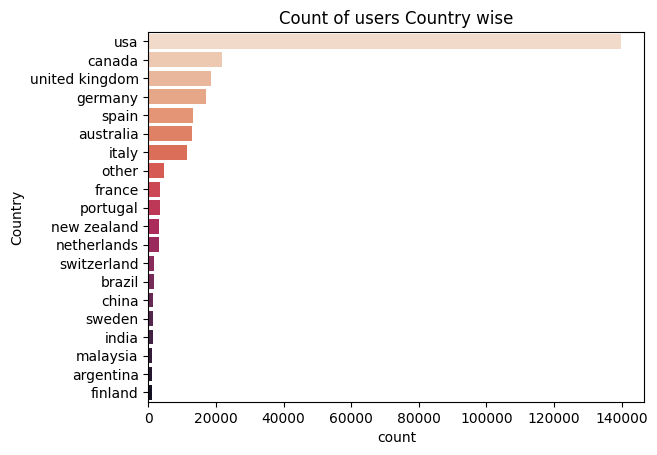

In [26]:
# Top 20 Countries having most userss
sns.countplot(y='Country',data=user,order=pd.value_counts(user['Country']).iloc[:20].index, palette='rocket_r')
plt.title('Count of users Country wise')

From the chart above we can see that USA had most number of users.

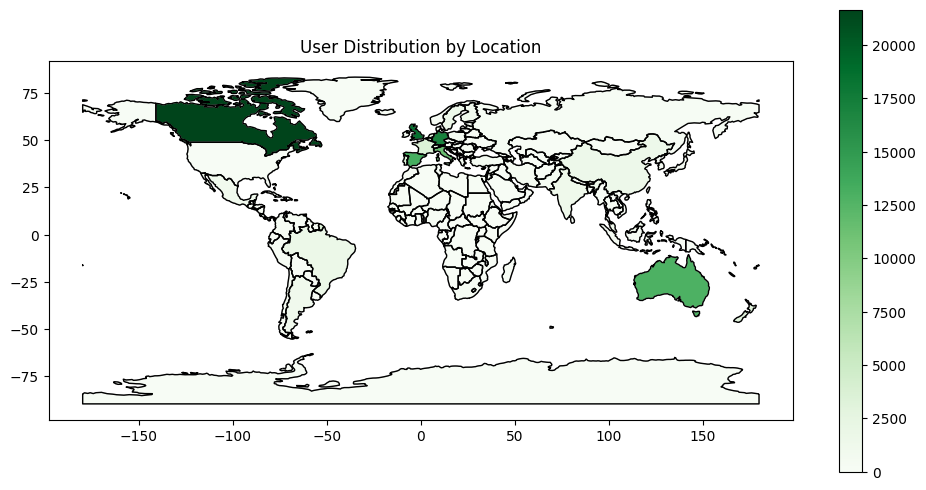

In [27]:
import geopandas as gpd
import matplotlib.pyplot as plt

# Count users per location
user_country = user["Country"].value_counts().reset_index()
user_country.columns = ["Country", "User_Count"]

# Load world map
world = gpd.read_file("https://github.com/nvkelso/natural-earth-vector/raw/master/geojson/ne_110m_admin_0_countries.geojson")

# Standardize country names
world["ADMIN"] = world["ADMIN"].str.strip().str.lower()
user_country["Country"] = user_country["Country"].str.strip().str.lower()

# Merge user data with world map
world = world.merge(user_country, how="left", left_on="ADMIN", right_on="Country", indicator=True)

# Fill missing values
if "User_Count" in world.columns:
    world["User_Count"] = world["User_Count"].fillna(0)
else:
    print("Merge failed: Check country name mismatches.")

# Plot map
fig, ax = plt.subplots(figsize=(12, 6))
world.boundary.plot(ax=ax, linewidth=1, color="black")
world.plot(column="User_Count", cmap="Greens", linewidth=0.8, ax=ax, edgecolor="0.8", legend=True)

plt.title("User Distribution by Location")
plt.show()


Drectly see from the map.

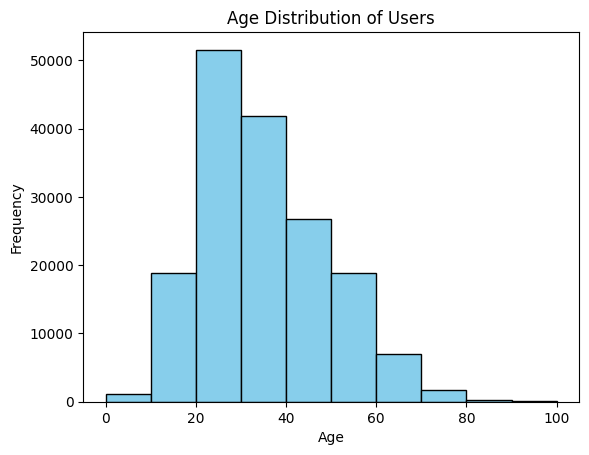

In [28]:
# Plotting histogram for age column
plt.hist(user['Age'],bins=[0,10,20,30,40,50,60,70,80,90,100],color='skyblue', edgecolor='black')

# Add title and labels
plt.title("Age Distribution of Users")
plt.xlabel("Age")
plt.ylabel("Frequency")

# Show the plot
plt.show()

Amazon books are more popular between 20-30s users

Text(0.5, 1.0, 'Find outlier data in Age column')

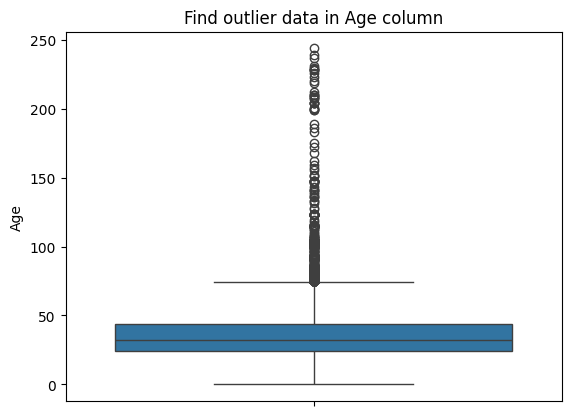

In [29]:
# finding outlier in age
sns.boxplot(y='Age', data=user)
plt.title('Find outlier data in Age column')

We have some outlier in the Age, which are above 100.

Treating Outliers in Age column

Text(0.5, 1.0, 'Age Distribution Plot')

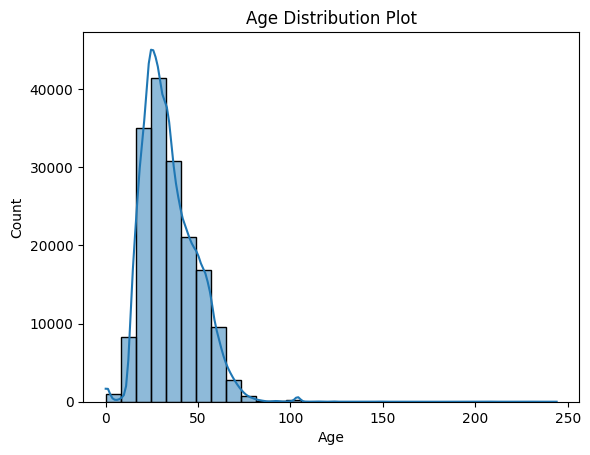

In [30]:
# To get distribution plot 
sns.histplot(user['Age'], bins=30, kde=True)
plt.title('Age Distribution Plot')

Age value's which are below 5 and above 100 do not make much sense in this case. Hence we replace these values by NaNs

In [31]:
# Replace outlier data into NaN
user.loc[(user.Age > 100) | (user.Age < 5), 'Age'] = np.nan

# Check data
user.isnull().sum()

User-ID         0
Age        112010
Country         0
dtype: int64

To fill these missing ages NaN, we cannot use median imputention directly throughout the range. Here we fill NaN with median imputation techniques on the basis of Country.

In [32]:
# Fill missing ages with median age on the basis of their Country
user['Age'] = user['Age'].fillna(user.groupby('Country')['Age'].transform('median'))

# Check the data
user.isnull().sum()

User-ID      0
Age        276
Country      0
dtype: int64

We still have 276 null in ages. For these missing ages, we fill them with a mean imputation technique.

In [33]:
# Fill the remaining Null with Mean of Age 
user['Age'].fillna(user['Age'].mean(),inplace=True)

# Check
user.isnull().sum()

User-ID    0
Age        0
Country    0
dtype: int64

### **2.2.2. Book Dataset**

In [34]:
# Display
book.head()

,ISBN,Book-Title,Book-Author,Year-Of-Publication,Publisher,Image-URL-S,Image-URL-M,Image-URL-L
0,0195153448,Classical Mythology,Mark P. O. Morford,2002,Oxford University Press,http://images.amazon.com/images/P/0195153448.0...,http://images.amazon.com/images/P/0195153448.0...,http://images.amazon.com/images/P/0195153448.0...
1,0002005018,Clara Callan,Richard Bruce Wright,2001,HarperFlamingo Canada,http://images.amazon.com/images/P/0002005018.0...,http://images.amazon.com/images/P/0002005018.0...,http://images.amazon.com/images/P/0002005018.0...
2,0060973129,Decision in Normandy,Carlo D'Este,1991,HarperPerennial,http://images.amazon.com/images/P/0060973129.0...,http://images.amazon.com/images/P/0060973129.0...,http://images.amazon.com/images/P/0060973129.0...
3,0374157065,Flu: The Story of the Great Influenza Pandemic...,Gina Bari Kolata,1999,Farrar Straus Giroux,http://images.amazon.com/images/P/0374157065.0...,http://images.amazon.com/images/P/0374157065.0...,http://images.amazon.com/images/P/0374157065.0...
4,0393045218,The Mummies of Urumchi,E. J. W. Barber,1999,W. W. Norton &amp; Company,http://images.amazon.com/images/P/0393045218.0...,http://images.amazon.com/images/P/0393045218.0...,http://images.amazon.com/images/P/0393045218.0...


Top 10 Authors which have written the most books.

Text(0.5, 1.0, 'Top 10 Authors')

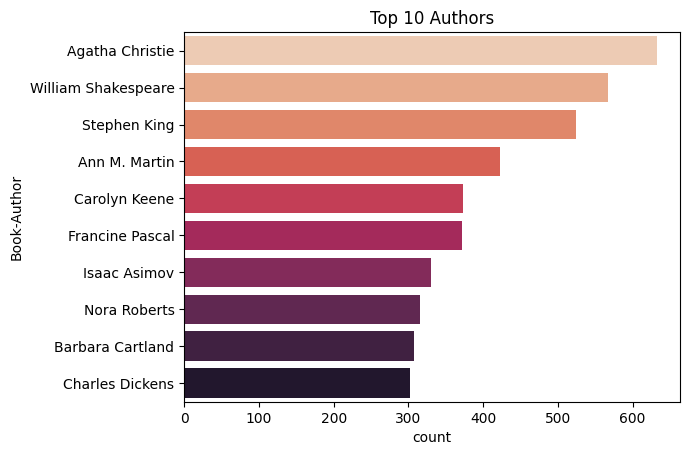

In [35]:
# Top 10 Authors which have written the most books.
sns.countplot(y='Book-Author',data=book,order=pd.value_counts(book['Book-Author']).iloc[:10].index, palette='rocket_r')
plt.title('Top 10 Authors')

The above chart shows top 10 Publisher which have published the most books.

Text(0.5, 1.0, 'Top 10 Publishers')

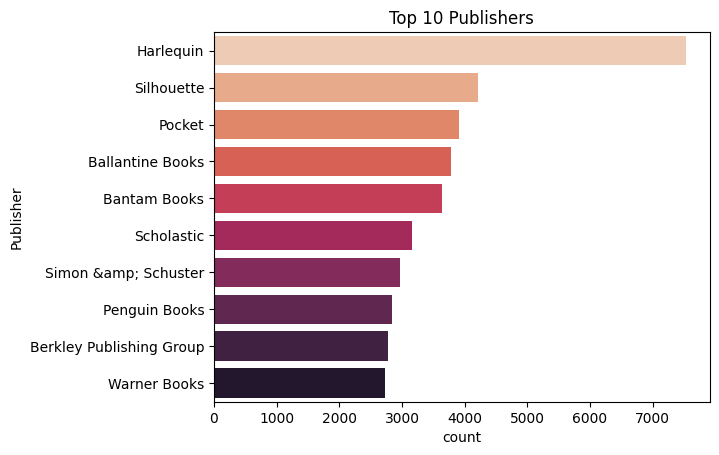

In [36]:
# Top 10 Publisher based on the amount of book puslished
sns.countplot(y='Publisher',data=book,order=pd.value_counts(book['Publisher']).iloc[:10].index, palette='rocket_r')
plt.title('Top 10 Publishers')

In [37]:
# Convert Year of Publication into string type
book['Year-Of-Publication']=book['Year-Of-Publication'].astype('str')

# Get unique year from the Year of publication
a=list(book['Year-Of-Publication'].unique())
a=set(a)
a=list(a)
a = [x for x in a if x is not None]
a.sort()
print(a)

['0', '1376', '1378', '1806', '1897', '1900', '1901', '1902', '1904', '1906', '1908', '1909', '1910', '1911', '1914', '1917', '1919', '1920', '1921', '1922', '1923', '1924', '1925', '1926', '1927', '1928', '1929', '1930', '1931', '1932', '1933', '1934', '1935', '1936', '1937', '1938', '1939', '1940', '1941', '1942', '1943', '1944', '1945', '1946', '1947', '1948', '1949', '1950', '1951', '1952', '1953', '1954', '1955', '1956', '1957', '1958', '1959', '1960', '1961', '1962', '1963', '1964', '1965', '1966', '1967', '1968', '1969', '1970', '1971', '1972', '1973', '1974', '1975', '1976', '1977', '1978', '1979', '1980', '1981', '1982', '1983', '1984', '1985', '1986', '1987', '1988', '1989', '1990', '1991', '1992', '1993', '1994', '1995', '1996', '1997', '1998', '1999', '2000', '2001', '2002', '2003', '2004', '2005', '2006', '2008', '2010', '2011', '2012', '2020', '2021', '2024', '2026', '2030', '2037', '2038', '2050', 'DK Publishing Inc', 'Gallimard']


From the display thr results above, we notice that there are two incorrect values under Year-Of-Publications: 'DK Publishing Inc', 'Gallimard'

In [38]:
# Invesitgate the rows having 'DK Publishing Inc' as yearOfPublication
book.loc[book['Year-Of-Publication'] == 'DK Publishing Inc',:]

,ISBN,Book-Title,Book-Author,Year-Of-Publication,Publisher,Image-URL-S,Image-URL-M,Image-URL-L
209538,078946697X,"DK Readers: Creating the X-Men, How It All Beg...",2000,DK Publishing Inc,http://images.amazon.com/images/P/078946697X.0...,http://images.amazon.com/images/P/078946697X.0...,http://images.amazon.com/images/P/078946697X.0...,NaN
221678,0789466953,"DK Readers: Creating the X-Men, How Comic Book...",2000,DK Publishing Inc,http://images.amazon.com/images/P/0789466953.0...,http://images.amazon.com/images/P/0789466953.0...,http://images.amazon.com/images/P/0789466953.0...,NaN


As it is shown above, there are some incorrect entries in Year-Of-Publication field. It looks like Publisher names 'DK Publishing Inc' and 'Gallimard' have been incorrectly loaded as Year-Of-Publication in dataset due to some errors in csv file. The values under Book-Auther and Year-Of-Pulication columns for these two have been switched.

In [39]:
# Now we make corrections
# ISBN '0789466953'
book.loc[book.ISBN == '0789466953','Year-Of-Publication'] = 2000
book.loc[book.ISBN == '0789466953','Book-Author'] = "James Buckley"
book.loc[book.ISBN == '0789466953','Publisher'] = "DK Publishing Inc"
book.loc[book.ISBN == '0789466953','Book-Title'] = "DK Readers: Creating the X-Men, How Comic Books Come to Life (Level 4: Proficient Readers)"

# ISBN '078946697X'
book.loc[book.ISBN == '078946697X','Year-Of-Publication'] = 2000
book.loc[book.ISBN == '078946697X','Book-Author'] = "Michael Teitelbaum"
book.loc[book.ISBN == '078946697X','Publisher'] = "DK Publishing Inc"
book.loc[book.ISBN == '078946697X','Book-Title'] = "DK Readers: Creating the X-Men, How It All Began (Level 4: Proficient Readers)"

# Recheck
book.loc[(book.ISBN == '0789466953') | (book.ISBN == '078946697X'),:]

,ISBN,Book-Title,Book-Author,Year-Of-Publication,Publisher,Image-URL-S,Image-URL-M,Image-URL-L
209538,078946697X,"DK Readers: Creating the X-Men, How It All Beg...",Michael Teitelbaum,2000,DK Publishing Inc,http://images.amazon.com/images/P/078946697X.0...,http://images.amazon.com/images/P/078946697X.0...,NaN
221678,0789466953,"DK Readers: Creating the X-Men, How Comic Book...",James Buckley,2000,DK Publishing Inc,http://images.amazon.com/images/P/0789466953.0...,http://images.amazon.com/images/P/0789466953.0...,NaN


In [40]:
# Investigate the rows having 'Gallimard' as yearOfPublication
book.loc[book['Year-Of-Publication'] == 'Gallimard',:]

,ISBN,Book-Title,Book-Author,Year-Of-Publication,Publisher,Image-URL-S,Image-URL-M,Image-URL-L
220731,2070426769,"Peuple du ciel, suivi de 'Les Bergers\"";Jean-M...",2003,Gallimard,http://images.amazon.com/images/P/2070426769.0...,http://images.amazon.com/images/P/2070426769.0...,http://images.amazon.com/images/P/2070426769.0...,NaN


In [41]:
# Make corrections
# ISBN '2070426769'
book.loc[book.ISBN == '2070426769','Year-Of-Publication'] = 2003
book.loc[book.ISBN == '2070426769','Book-Author'] = "Jean-Marie Gustave Le ClÃ?Â©zio"
book.loc[book.ISBN == '2070426769','Publisher'] = "Gallimard"
book.loc[book.ISBN == '2070426769','Book-Title'] = "Peuple du ciel, suivi de 'Les Bergers"

# Recheck
book.loc[book.ISBN == '2070426769',:]

,ISBN,Book-Title,Book-Author,Year-Of-Publication,Publisher,Image-URL-S,Image-URL-M,Image-URL-L
220731,2070426769,"Peuple du ciel, suivi de 'Les Bergers",Jean-Marie Gustave Le ClÃ?Â©zio,2003,Gallimard,http://images.amazon.com/images/P/2070426769.0...,http://images.amazon.com/images/P/2070426769.0...,NaN


In [42]:
# Make Year again as Integer
book['Year-Of-Publication']=book['Year-Of-Publication'].astype(int)

In [43]:
# Now Year-Of-Publication has all values as integers
print(sorted(book['Year-Of-Publication'].unique()))

[np.int64(0), np.int64(1376), np.int64(1378), np.int64(1806), np.int64(1897), np.int64(1900), np.int64(1901), np.int64(1902), np.int64(1904), np.int64(1906), np.int64(1908), np.int64(1909), np.int64(1910), np.int64(1911), np.int64(1914), np.int64(1917), np.int64(1919), np.int64(1920), np.int64(1921), np.int64(1922), np.int64(1923), np.int64(1924), np.int64(1925), np.int64(1926), np.int64(1927), np.int64(1928), np.int64(1929), np.int64(1930), np.int64(1931), np.int64(1932), np.int64(1933), np.int64(1934), np.int64(1935), np.int64(1936), np.int64(1937), np.int64(1938), np.int64(1939), np.int64(1940), np.int64(1941), np.int64(1942), np.int64(1943), np.int64(1944), np.int64(1945), np.int64(1946), np.int64(1947), np.int64(1948), np.int64(1949), np.int64(1950), np.int64(1951), np.int64(1952), np.int64(1953), np.int64(1954), np.int64(1955), np.int64(1956), np.int64(1957), np.int64(1958), np.int64(1959), np.int64(1960), np.int64(1961), np.int64(1962), np.int64(1963), np.int64(1964), np.int64(1

Some of the values for Year-Of_Publication are invalid: Values greater than 2024

We assumed that the years after 2024 to be invalid and set invalid years as NaN. Then we handle these NaN values using median imputation

In [44]:
# For replacing year as 0 or greater than 2024 to Nan
book.loc[(book['Year-Of-Publication'] > 2024) | (book['Year-Of-Publication'] == 0),'Year-Of-Publication'] = np.nan

# Replace NaNs with median of Year-Of-Publication
book['Year-Of-Publication'].fillna(round(book['Year-Of-Publication'].median()), inplace=True)

In [45]:
# Drop last three columns containing image URLs which will not be required for analysis
book.drop(['Image-URL-S', 'Image-URL-M', 'Image-URL-L'],axis=1,inplace=True)

In [46]:
book.isnull().sum()

ISBN                   0
Book-Title             0
Book-Author            2
Year-Of-Publication    0
Publisher              2
dtype: int64

We notice that there are 2 missing values in Book-Author and 2 missing values in Publisher. We fill these values with 'others'.

In [47]:
# Looking for NaN in Author 
book[book['Book-Author'].isnull()]

,ISBN,Book-Title,Book-Author,Year-Of-Publication,Publisher
118033,0751352497,A+ Quiz Masters:01 Earth,NaN,1999.0,Dorling Kindersley
187689,9627982032,The Credit Suisse Guide to Managing Your Perso...,NaN,1995.0,Edinburgh Financial Publishing


In [48]:
# Filling NaN of Book-Author with others
book['Book-Author'].fillna('other',inplace=True)

In [49]:
# Looking for NaN Publisher
book.loc[book.Publisher.isnull()]

,ISBN,Book-Title,Book-Author,Year-Of-Publication,Publisher
128890,193169656X,Tyrant Moon,Elaine Corvidae,2002.0,NaN
129037,1931696993,Finders Keepers,Linnea Sinclair,2001.0,NaN


In [50]:
# Filling Nan of Publisher with others
book['Publisher'].fillna('other',inplace=True)

In [51]:
#Recheck
book.isnull().sum()

ISBN                   0
Book-Title             0
Book-Author            0
Year-Of-Publication    0
Publisher              0
dtype: int64

### **2.2.3. Ratings Dataset**

In [52]:
# Display
rating.head()

,User-ID,ISBN,Book-Rating
0,276725,034545104X,0
1,276726,0155061224,5
2,276727,0446520802,0
3,276729,052165615X,3
4,276729,0521795028,6


In [53]:
# Check for any null vlaues
rating.isnull().sum()

User-ID        0
ISBN           0
Book-Rating    0
dtype: int64

Rating dataset should have books only which exist in our books dataset

In [54]:
# Making new dataset which has rating of books that exist in our dataset
new_rating = rating[rating["ISBN"].isin(book["ISBN"])]
rating.shape,new_rating.shape

((1149780, 3), (1031136, 3))

Books that are not part of book dataset gets dropped off

Ratings dataset should have ratings from users which exist in users dataset.

In [55]:
# Check for users in rating with our user dataset
print("Shape of dataset before dropping",new_rating.shape)
new_rating = new_rating[new_rating['User-ID'].isin(user['User-ID'])]
print("shape of dataset after dropping",new_rating.shape)

Shape of dataset before dropping (1031136, 3)
shape of dataset after dropping (1031136, 3)


It can be seen that no new user was there in ratings dataset.

Let's see distribution of ratings

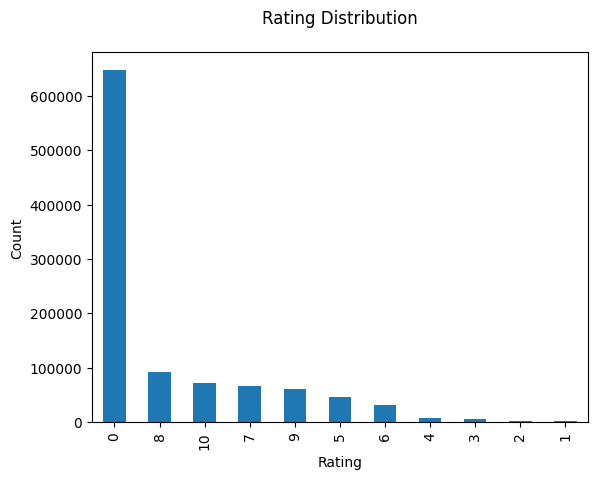

In [56]:
# Plotting graph for distribution of ratings 
new_rating['Book-Rating'].value_counts(sort=True).plot(kind='bar')
plt.title('Rating Distribution\n')
plt.xlabel('Rating')
plt.ylabel('Count')
plt.show()

The ratings are very unevenly distributed, and the vast majority of ratings are 0. 

Ratings are either explicit, expressed on a scale from 1-10 higher values denoting higher appreciation, or implicit, expressed by 0.Hence segragating implicit(rating=0) and explict(rating>0) ratings datasets

In [57]:
# Segragating implicit and explict ratings datasets
ratings_explicit = new_rating[new_rating['Book-Rating'] != 0]
ratings_implicit = new_rating[new_rating['Book-Rating'] == 0]

# Print the size
print('ratings_explicit dataset shape',ratings_explicit.shape)
print('ratings_implicit dataset',ratings_implicit.shape)

ratings_explicit dataset shape (383842, 3)
ratings_implicit dataset (647294, 3)


<Axes: xlabel='Book-Rating', ylabel='count'>

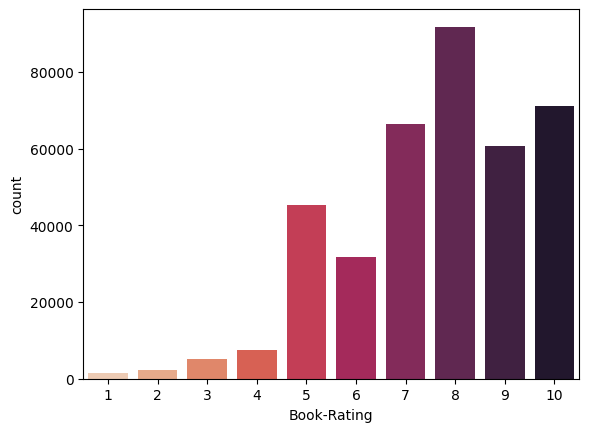

In [58]:
# Countplot for explicit ratings
sns.countplot(data=ratings_explicit , x='Book-Rating', palette='rocket_r')

Higher ratings are more common amongst users and rating 8 has been rated highest number of times

Investigate the top 5 books which are rated by most number of users.

In [59]:
# Fetch books that are most count of rating
rating_count = pd.DataFrame(ratings_explicit.groupby('ISBN')['Book-Rating'].count())
rating_count.sort_values('Book-Rating', ascending=False).head()

,Book-Rating
ISBN,
0316666343,707
0971880107,581
0385504209,487
0312195516,383
0060928336,320


The book with ISBN '0316666343' received the most rating counts. Now let's find out the information of these top rated books.

In [60]:
# Details about Books from rating_count
most_rated_books = pd.DataFrame(['0316666343', '0971880107', '0385504209', '0312195516', '0060928336'], index=np.arange(5), columns = ['ISBN'])
most_rated_books_summary = pd.merge(most_rated_books, book, on='ISBN')
most_rated_books_summary

,ISBN,Book-Title,Book-Author,Year-Of-Publication,Publisher
0,0316666343,The Lovely Bones: A Novel,Alice Sebold,2002.0,"Little, Brown"
1,0971880107,Wild Animus,Rich Shapero,2004.0,Too Far
2,0385504209,The Da Vinci Code,Dan Brown,2003.0,Doubleday
3,0312195516,The Red Tent (Bestselling Backlist),Anita Diamant,1998.0,Picador USA
4,0060928336,Divine Secrets of the Ya-Ya Sisterhood: A Novel,Rebecca Wells,1997.0,Perennial


The book that received the most rating counts in this data set is Alice Sebold’s “The Lovely Bones: A Novel”. 

And there is something in common among these five books that received the most rating counts — they are all novels. 

So it is conclusive that novels are popular and likely receive more ratings.

In [61]:
# Create column Rating average 
ratings_explicit['Avg_Rating']=ratings_explicit.groupby('ISBN')['Book-Rating'].transform("mean")
# Create column Rating sum
ratings_explicit['Total_No_Of_Users_Rated']=ratings_explicit.groupby('ISBN')['Book-Rating'].transform('count')

In [62]:
ratings_explicit.head()

,User-ID,ISBN,Book-Rating,Avg_Rating,Total_No_Of_Users_Rated
1,276726,0155061224,5,5.000000,1
3,276729,052165615X,3,3.000000,1
4,276729,0521795028,6,6.000000,1
8,276744,038550120X,7,7.580247,81
16,276747,0060517794,9,8.000000,30


### Merging All Datasets

In [63]:
# Merging all dataset to get a Final Dataset with all infromation
Final_Dataset=user.copy()
Final_Dataset=Final_Dataset.merge(ratings_explicit,on="User-ID")
Final_Dataset=Final_Dataset.merge(book,on="ISBN")


In [64]:
Final_Dataset.head()

,User-ID,Age,Country,ISBN,Book-Rating,Avg_Rating,Total_No_Of_Users_Rated,Book-Title,Book-Author,Year-Of-Publication,Publisher
0,8,33.0,canada,0002005018,5,7.666667,9,Clara Callan,Richard Bruce Wright,2001.0,HarperFlamingo Canada
1,8,33.0,canada,074322678X,5,5.000000,1,Where You'll Find Me: And Other Stories,Ann Beattie,2002.0,Scribner
2,8,33.0,canada,0887841740,5,5.000000,1,The Middle Stories,Sheila Heti,2004.0,House of Anansi Press
3,8,33.0,canada,1552041778,5,5.000000,1,Jane Doe,R. J. Kaiser,1999.0,Mira Books
4,8,33.0,canada,1567407781,6,6.000000,1,The Witchfinder (Amos Walker Mystery Series),Loren D. Estleman,1998.0,Brilliance Audio - Trade


In [65]:
# Check
Final_Dataset.isnull().sum()

User-ID                    0
Age                        0
Country                    0
ISBN                       0
Book-Rating                0
Avg_Rating                 0
Total_No_Of_Users_Rated    0
Book-Title                 0
Book-Author                0
Year-Of-Publication        0
Publisher                  0
dtype: int64

In [66]:
Final_Dataset.shape

(383842, 11)

# **3. Model Implementation and Prediction**

## **3.1 For new users - Popularity Based Filtering**

- Popularity based recommendation system works with the trend. 
- It uses the items which are in trend right now. 
- E.g. if any book which is usually bought by every new user then there are chances that it may suggest that book to the user who just signed up.

**Book weighted average formula:**

Weighted Rating(WR)=[vR/(v+m)]+[mC/(v+m)], where
- v: the number of votes for the books
- m: the minimum votes required to be listed in the chart
- R: the average rating of the book
- C: the mean vote across the whole report
We need to find the values of v,m,R,C.

In [67]:
# Get C and m
C= Final_Dataset['Avg_Rating'].mean()
m= Final_Dataset['Total_No_Of_Users_Rated'].quantile(0.90)

# Get a books who had ratings more than 90 percentile
Top_Books = Final_Dataset.loc[Final_Dataset['Total_No_Of_Users_Rated'] >= m]
print(f'C={C} , m={m}')

# Check the size
Top_Books.shape

C=7.626700569505161 , m=64.0


(38570, 11)

We used 90th percentile as our cutoff, i.e. for a book to feature in the charts, it must have more votes than at least 90% of the books in the list.

There are 38570 books which qualify to be in this list. 

Now, we need to calculate our metric for each qualified book. To do this, we will define a function: weighted_rating() and define a new feature score, of which we’ll calculate the value by applying this function to our DataFrame of qualified books

In [68]:
# Function for weighted average
def weighted_rating(x,C=C,m=m):
  v=x['Total_No_Of_Users_Rated']
  R=x['Avg_Rating']
  return (v/(v+m) * R) + (m/(m+v) * C)

# Apply function of Top_Books dataset
Top_Books["Score"]=Top_Books.apply(weighted_rating,axis=1)

# Sort Dataset on the basis of Score
Top_Books.sort_values("Score",ascending=False,inplace=True)

# Drop duplicates
Top_Books.drop_duplicates('ISBN',inplace=True)

# Get DataFrame of Top 20 Books to recommend every new user.
popular_books = Top_Books[['Book-Title', 'Total_No_Of_Users_Rated', 'Avg_Rating', 'Score']].reset_index(drop=True).head(20)
popular_books

,Book-Title,Total_No_Of_Users_Rated,Avg_Rating,Score
0,Harry Potter and the Goblet of Fire (Book 4),137,9.262774,8.741835
1,Harry Potter and the Sorcerer's Stone (Harry P...,313,8.939297,8.716469
2,Harry Potter and the Order of the Phoenix (Boo...,206,9.033981,8.700403
3,To Kill a Mockingbird,214,8.943925,8.640679
4,Harry Potter and the Prisoner of Azkaban (Book 3),133,9.082707,8.609690
5,"The Return of the King (The Lord of the Rings,...",77,9.402597,8.596517
6,Harry Potter and the Prisoner of Azkaban (Book 3),141,9.035461,8.595653
7,Harry Potter and the Sorcerer's Stone (Book 1),119,8.983193,8.508791
8,Harry Potter and the Chamber of Secrets (Book 2),189,8.783069,8.490549
9,Harry Potter and the Chamber of Secrets (Book 2),126,8.920635,8.484783


Popularity recommender provides a general recommenddation based on the overall trends to all the users. 

However, they are not sensitive to the interests, demographic and other factors of a particular user.

We take 60% of overall popular books and 40% specific popular books.

In [69]:
# Load dataset
df = Final_Dataset  # Your dataset

# **1️⃣ Compute Popular Books using Weighted Rating**
C = df["Avg_Rating"].mean()  # Global average rating
m = df["Total_No_Of_Users_Rated"].quantile(0.90)  # Minimum votes required to be considered

def weighted_rating(x, C=C, m=m):
    """Computes weighted rating based on vote count & average rating"""
    v = x['Total_No_Of_Users_Rated']
    R = x['Avg_Rating']
    return (v / (v + m) * R) + (m / (m + v) * C)

# Apply weighted rating formula
df["Score"] = df.apply(weighted_rating, axis=1)

# Sort books based on weighted score
df.sort_values("Score", ascending=False, inplace=True)

# Drop duplicate books (same ISBN)
df.drop_duplicates('ISBN', inplace=True)

# **Top 20 Books for All Users**
popular_books = df[['ISBN', 'Book-Title', 'Total_No_Of_Users_Rated', 'Avg_Rating', 'Score']].reset_index(drop=True).head(20)
popular_books_list = popular_books["ISBN"].tolist()

# **2️⃣ Compute Location-Based Books (Top 40%)**
def get_location_based_books(user_country, df, top_n=20):
    """Fetch top-N books based on the user's country preference"""
    location_books = df[df['Country'] == user_country]
    return location_books.sort_values(by="Total_No_Of_Users_Rated", ascending=False).head(top_n)['ISBN'].tolist()

# **3️⃣ Generate Recommendations Based on Input Country**
def recommend_for_country(user_country, top_n=20):
    """Recommend books using a hybrid strategy: 60% popular + 40% location-based"""
    location_books = get_location_based_books(user_country, df, top_n=int(0.4 * top_n))

    # Ensure we don't sample more than available books
    num_popular_books = min(len(popular_books_list), int(0.6 * top_n))
    num_location_books = min(len(location_books), int(0.4 * top_n))

    recommended_books = list(np.random.choice(popular_books_list, size=num_popular_books, replace=False)) + \
                         list(np.random.choice(location_books, size=num_location_books, replace=False))
    
    return df[df['ISBN'].isin(recommended_books)][['Book-Title', 'ISBN', 'Avg_Rating', 'Total_No_Of_Users_Rated']].reset_index(drop=True).drop_duplicates().head(top_n)

# **4️⃣ Test with 'us'**
country_input = "us"
top_books_for_country = recommend_for_country(country_input, top_n=20)
top_books_for_country

,Book-Title,ISBN,Avg_Rating,Total_No_Of_Users_Rated
0,Harry Potter and the Order of the Phoenix (Boo...,043935806X,9.033981,206
1,To Kill a Mockingbird,0446310786,8.943925,214
2,Harry Potter and the Prisoner of Azkaban (Book 3),0439136369,9.082707,133
3,"The Return of the King (The Lord of the Rings,...",0345339738,9.402597,77
4,Harry Potter and the Sorcerer's Stone (Book 1),0590353403,8.983193,119
5,Harry Potter and the Chamber of Secrets (Book 2),0439064872,8.783069,189
6,"The Two Towers (The Lord of the Rings, Part 2)",0345339711,9.120482,83
7,Harry Potter and the Goblet of Fire (Book 4),0439139600,8.954545,110
8,The Fellowship of the Ring (The Lord of the Ri...,0345339703,8.839695,131
9,The Hobbit : The Enchanting Prelude to The Lor...,0345339681,8.739130,161


## **3.2 For currene users**
### **3.2.1 User-User Collaborative Filtering Recommender System**

In [75]:
ratings_explicit.head()

,User-ID,ISBN,Book-Rating,Avg_Rating,Total_No_Of_Users_Rated
1,276726,0155061224,5,5.000000,1
3,276729,052165615X,3,3.000000,1
4,276729,0521795028,6,6.000000,1
8,276744,038550120X,7,7.580247,81
16,276747,0060517794,9,8.000000,30


For better Collaborative Filtering:
- Keeping only users with sufficient rating history(>100) improves the quality of user-user similarity calculations.
- If users have too few ratings, the system may generate unreliable recommendations.
- Filtering out users with insufficient data reduces computation time and memory usage, improving the data efficiency.

In [76]:
# Grouping User-Book Interactions

# Groups the dataset by book (ISBN) and user (User-ID) and counts the number of interactions (i.e., ratings) for each (ISBN, User-ID) pair.
user_user_df = ratings_explicit.groupby(['ISBN', 'User-ID']).size().groupby('User-ID').size()

# Counts the total number of unique users in the dataset.
print('# of users: %d' % len(user_user_df))

# Filtering Users with At Least 100 Interactions
users_with_enough_interactions_df = user_user_df[user_user_df >= 100].reset_index()[['User-ID']]

# Count Users with At Least 100 Interactions
print('# of users with at least 100 interactions: %d' % len(users_with_enough_interactions_df))

# of users: 68091
# of users with at least 100 interactions: 449


The dataset initially had 68,091 users and only 449 users have rated at least 100 books.

This step filters out inactive users to improve recommendation quality.

In [77]:
# Filtering User-Book Interactions
print('# of interactions: %d' % len(ratings_explicit))

# Filters interactions to only include users with at least 100 ratings and uses a right join so only users present in users_with_enough_interactions_df remain.
interactions_from_selected_users_df = ratings_explicit.merge(users_with_enough_interactions_df, how = 'right', left_on = 'User-ID', right_on = 'User-ID')
print('# of interactions from users with at least 100 interactions: %d' % len(interactions_from_selected_users_df))

# of interactions: 383842
# of interactions from users with at least 100 interactions: 103271


In [78]:
interactions_from_selected_users_df.head(10)

,User-ID,ISBN,Book-Rating,Avg_Rating,Total_No_Of_Users_Rated
0,2033,0030020786,7,7.000000,1
1,2033,0060248025,10,8.766667,30
2,2033,0060256664,10,8.333333,6
3,2033,0060256737,10,9.045455,22
4,2033,0060950536,10,9.400000,5
5,2033,0061020419,7,7.000000,1
6,2033,0061020427,6,6.000000,1
7,2033,0061056278,10,9.000000,2
8,2033,0061056286,8,7.666667,3
9,2033,0061056294,9,7.000000,2


Now we try to smooth the User Preferences. 

We defines a log transformation function to smooth ratings, which helps in handling highly skewed rating distributions.

In [79]:
import math

# Defines a log transformation function to smooth ratings
def smooth_user_preference(x):
    return math.log(1+x, 2)

# Groups by User-ID and ISBN, sums ratings, then applies the smoothing function.  
ratings_full_df = interactions_from_selected_users_df.groupby(['User-ID','ISBN'])['Book-Rating'].sum().apply(smooth_user_preference).reset_index()
print('# of unique user/book ratings: %d' % len(ratings_full_df))
ratings_full_df.head()

# of unique user/book ratings: 103271


,User-ID,ISBN,Book-Rating
0,2033,0030020786,3.000000
1,2033,0060248025,3.459432
2,2033,0060256664,3.459432
3,2033,0060256737,3.459432
4,2033,0060950536,3.459432


Splits the dataset into 80% training and 20% testing.

Uses stratified sampling to ensure the same user distribution in both sets.

In [80]:
# Train-test split
ratings_train_df, ratings_test_df = train_test_split(ratings_full_df,
                                   stratify=ratings_full_df['User-ID'], 
                                   test_size=0.20,
                                   random_state=42)

print('# interactions on Train set: %d' % len(ratings_train_df))
print('# interactions on Test set: %d' % len(ratings_test_df))

# interactions on Train set: 82616
# interactions on Test set: 20655


In [81]:
# Creating a sparse pivot table with users in rows and items in columns
users_items_pivot_matrix_df = ratings_train_df.pivot(index='User-ID', 
                                                          columns='ISBN', 
                                                          values='Book-Rating').fillna(0)

users_items_pivot_matrix_df.head()

ISBN,0000913154,000104687X,0001047213,0001047973,000104799X,0001048082,0001053736,0001055607,0001056107,0001845039,...,B00007FYKW,B00008RWPV,B00009NDAN,B0000DYXID,B0000T6KHI,B0000VZEJQ,B0000X8HIE,B00013AX9E,B0001I1KOG,B000234N3A
User-ID,,,,,,,,,,,,,,,,,,,,,
2033,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2110,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2276,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4017,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4385,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [82]:
# Create the User-Item Matrix
# Converts the sparse pivot table (users as rows, books as columns) into a NumPy array for processing.

users_items_pivot_matrix = users_items_pivot_matrix_df.values
users_items_pivot_matrix[:10]

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [83]:
# Extracts the list of user IDs corresponding to rows in the pivot matrix
users_ids = list(users_items_pivot_matrix_df.index)
users_ids[:10]

[2033, 2110, 2276, 4017, 4385, 5582, 6242, 6251, 6543, 6575]

Apply Singular Value Decomposition (SVD)

In [84]:
# Number of latent factors
NUMBER_OF_FACTORS_MF = 15

# Performs matrix factorization of the original user item matrix
U, sigma, Vt = svds(users_items_pivot_matrix, k = NUMBER_OF_FACTORS_MF)

In [85]:
users_items_pivot_matrix.shape

(449, 55743)

In [86]:
U.shape

(449, 15)

In [87]:
# Convert singular values into diagonal matrix
sigma = np.diag(sigma)
sigma.shape

(15, 15)

In [88]:
Vt.shape

(15, 55743)

After the factorization, we reconstruct the original matrix by multiplying its factors. 

The resulting matrix is not sparse any more. It was generated predictions for items the user have not yet interaction, which we will use for recommendations.

In [89]:
all_user_predicted_ratings = np.dot(np.dot(U, sigma), Vt) 
all_user_predicted_ratings

array([[ 1.48048195e-02,  2.31728082e-03,  2.74202603e-03, ...,
         2.27788796e-04,  5.49322969e-04,  1.26270997e-02],
       [-7.38279388e-04, -8.94254584e-04, -1.05816668e-03, ...,
         8.58241199e-05,  1.78651132e-04,  4.24690377e-03],
       [-2.00559626e-03, -1.73047641e-03, -2.04766350e-03, ...,
         1.78220412e-04,  4.04160623e-04,  7.29766631e-03],
       ...,
       [ 4.20550556e-03,  1.96625381e-03,  2.32665764e-03, ...,
         2.49809614e-04,  4.73258210e-04,  8.35154052e-03],
       [ 1.13675090e-02, -2.21445596e-03, -2.62035392e-03, ...,
         3.41186005e-04,  6.59446393e-04,  1.16707765e-02],
       [-1.44606285e-03,  5.14009860e-03,  6.08225124e-03, ...,
         8.58660344e-05,  1.46974496e-04,  2.89210573e-03]])

In [90]:
all_user_predicted_ratings.shape

(449, 55743)

Converting Predictions into a DataFrame

In [91]:
cf_preds_df = pd.DataFrame(all_user_predicted_ratings, columns = users_items_pivot_matrix_df.columns, index=users_ids).transpose()
cf_preds_df.head()

,2033,2110,2276,4017,4385,5582,6242,6251,6543,6575,...,269566,270713,271448,271705,273113,274061,274301,275970,277427,278418
ISBN,,,,,,,,,,,,,,,,,,,,,
0000913154,0.014805,-0.000738,-0.002006,0.000747,-0.001927,-0.003498,-0.002684,0.006589,0.001398,0.013279,...,0.000506,0.003200,-0.001789,0.007501,-0.011989,0.001284,0.007515,0.004206,0.011368,-0.001446
000104687X,0.002317,-0.000894,-0.001730,0.016672,-0.000697,0.008500,0.013733,0.007379,-0.003087,0.015761,...,-0.002449,0.013465,-0.001160,0.013659,-0.004606,-0.006250,0.007927,0.001966,-0.002214,0.005140
0001047213,0.002742,-0.001058,-0.002048,0.019728,-0.000825,0.010058,0.016251,0.008732,-0.003653,0.018650,...,-0.002898,0.015933,-0.001372,0.016162,-0.005451,-0.007395,0.009380,0.002327,-0.002620,0.006082
0001047973,0.002742,-0.001058,-0.002048,0.019728,-0.000825,0.010058,0.016251,0.008732,-0.003653,0.018650,...,-0.002898,0.015933,-0.001372,0.016162,-0.005451,-0.007395,0.009380,0.002327,-0.002620,0.006082
000104799X,0.000983,0.000372,0.000752,0.002271,0.000237,0.001083,0.001158,0.002106,0.001664,0.003783,...,0.001298,0.002130,0.002638,0.001052,0.001605,0.002180,0.002125,0.000821,0.001370,0.000304


In [92]:
len(cf_preds_df.columns)

449

In [93]:
# Book Metadata Loading
global book
book.head()

,ISBN,Book-Title,Book-Author,Year-Of-Publication,Publisher
0,0195153448,Classical Mythology,Mark P. O. Morford,2002.0,Oxford University Press
1,0002005018,Clara Callan,Richard Bruce Wright,2001.0,HarperFlamingo Canada
2,0060973129,Decision in Normandy,Carlo D'Este,1991.0,HarperPerennial
3,0374157065,Flu: The Story of the Great Influenza Pandemic...,Gina Bari Kolata,1999.0,Farrar Straus Giroux
4,0393045218,The Mummies of Urumchi,E. J. W. Barber,1999.0,W. W. Norton &amp; Company


#### Collaborative Filtering Recommendation Class

In [94]:
class CFRecommender:
    
    MODEL_NAME = 'Collaborative Filtering'
    
    # Class Initialization
    def __init__(self, cf_predictions_df):
        self.cf_predictions_df = cf_predictions_df  # Stores the predicted ratings matrix.

    # Get Model Name    
    def get_model_name(self):
        return self.MODEL_NAME

    # Generating Recommendations    
    def recommend_items(self, user_id, items_to_ignore=[], topn=10):

        # Get User's Predicted Ratings
        sorted_user_predictions = self.cf_predictions_df[user_id].sort_values(ascending=False).reset_index().rename(columns={user_id: 'recStrength'})

        # Filter Out Books the User Has Already Seen
        recommendations_df = sorted_user_predictions[~sorted_user_predictions['ISBN'].isin(items_to_ignore)].sort_values('recStrength', ascending = False).head(topn)

        # Merge with Book Metadata
        recommendations_df=recommendations_df.merge(book,on='ISBN',how='inner')

        # Return the Top N Recommendations
        recommendations_df=recommendations_df[['ISBN','Book-Title','recStrength']]

        return recommendations_df



cf_recommender_model = CFRecommender(cf_preds_df)

In [95]:
# Indexing Data for Faster Lookup
ratings_full_indexed_df = ratings_full_df.set_index('User-ID')
ratings_train_indexed_df = ratings_train_df.set_index('User-ID')
ratings_test_indexed_df = ratings_test_df.set_index('User-ID')

In [96]:
# Getting Books a User Has Interacted With
def get_items_interacted(UserID, interactions_df):
    interacted_items = interactions_df.loc[UserID]['ISBN']
    return set(interacted_items if type(interacted_items) == pd.Series else [interacted_items])

In [97]:
# 1
class ModelRecommender:

    # Function for getting the set of items which a user has not interacted with
    def get_not_interacted_items_sample(self, UserID, sample_size, seed=42):
        interacted_items = get_items_interacted(UserID, ratings_full_indexed_df)
        all_items = set(ratings_explicit['ISBN'])
        non_interacted_items = all_items - interacted_items

        random.seed(seed)
        non_interacted_items_sample = random.sample(non_interacted_items, sample_size)
        return set(non_interacted_items_sample)

    # Function to verify whether a particular item_id was present in the set of top N recommended items
    def _verify_hit_top_n(self, item_id, recommended_items, topn):        
            try:
                index = next(i for i, c in enumerate(recommended_items) if c == item_id)
            except:
                index = -1
            hit = int(index in range(0, topn))
            return hit, index
    
    # Function to evaluate the performance of model for each user
    def evaluate_model_for_user(self, model, person_id):
        
        # Getting the items in test set
        interacted_values_testset = ratings_test_indexed_df.loc[person_id]
        
        if type(interacted_values_testset['ISBN']) == pd.Series:
            person_interacted_items_testset = set(interacted_values_testset['ISBN'])
        else:
            person_interacted_items_testset = set([int(interacted_values_testset['ISBN'])])
            
        interacted_items_count_testset = len(person_interacted_items_testset) 

        # Getting a ranked recommendation list from the model for a given user
        person_recs_df = model.recommend_items(person_id, items_to_ignore=get_items_interacted(person_id, ratings_train_indexed_df),topn=10000000000)
        print('Recommendation for User-ID = ',person_id)
        print(person_recs_df.head(10))

        # Function to evaluate the performance of model at overall level
    def recommend_book(self, model ,userid):
        
        person_metrics = self.evaluate_model_for_user(model, userid)  
        return

model_recommender = ModelRecommender()    

In [98]:
# 2
print(list(ratings_full_indexed_df.index.values))

[np.int64(2033), np.int64(2033), np.int64(2033), np.int64(2033), np.int64(2033), np.int64(2033), np.int64(2033), np.int64(2033), np.int64(2033), np.int64(2033), np.int64(2033), np.int64(2033), np.int64(2033), np.int64(2033), np.int64(2033), np.int64(2033), np.int64(2033), np.int64(2033), np.int64(2033), np.int64(2033), np.int64(2033), np.int64(2033), np.int64(2033), np.int64(2033), np.int64(2033), np.int64(2033), np.int64(2033), np.int64(2033), np.int64(2033), np.int64(2033), np.int64(2033), np.int64(2033), np.int64(2033), np.int64(2033), np.int64(2033), np.int64(2033), np.int64(2033), np.int64(2033), np.int64(2033), np.int64(2033), np.int64(2033), np.int64(2033), np.int64(2033), np.int64(2033), np.int64(2033), np.int64(2033), np.int64(2033), np.int64(2033), np.int64(2033), np.int64(2033), np.int64(2033), np.int64(2033), np.int64(2033), np.int64(2033), np.int64(2033), np.int64(2033), np.int64(2033), np.int64(2033), np.int64(2033), np.int64(2033), np.int64(2033), np.int64(2033), np.int6

In [99]:
# 3
user=int(input("Enter User ID from above list for book recommendation  "))
model_recommender.recommend_book(cf_recommender_model,user)

Recommendation for User-ID =  11676
         ISBN                                         Book-Title  recStrength
0  0385504209                                  The Da Vinci Code     0.101774
1  0452282152                          Girl with a Pearl Earring     0.077728
2  0312980140                  Seven Up (A Stephanie Plum Novel)     0.077096
3  0553250531                               The Valley of Horses     0.063579
4  0440214041                                  The Pelican Brief     0.062448
5  0440212561                                          Outlander     0.060398
6  0440220602                                        The Chamber     0.060067
7  0743418174                                        Good in Bed     0.059938
8  0385492081  Into Thin Air : A Personal Account of the Mt. ...     0.059290
9  0446606812                                Message in a Bottle     0.058295


In [100]:
# Top-N accuracy metrics consts
EVAL_RANDOM_SAMPLE_NON_INTERACTED_ITEMS = 100

class ModelEvaluator:

    # Function for getting the set of items which a user has not interacted with
    def get_not_interacted_items_sample(self, UserID, sample_size, seed=42):
        interacted_items = get_items_interacted(UserID, ratings_full_indexed_df)
        all_items = set(ratings_explicit['ISBN'])
        non_interacted_items = all_items - interacted_items

        random.seed(seed)
        non_interacted_items_sample = random.sample(non_interacted_items, sample_size)
        return set(non_interacted_items_sample)

    # Function to verify whether a particular item_id was present in the set of top N recommended items
    def _verify_hit_top_n(self, item_id, recommended_items, topn):        
            try:
                index = next(i for i, c in enumerate(recommended_items) if c == item_id)
            except:
                index = -1
            hit = int(index in range(0, topn))
            return hit, index
    
    # Function to evaluate the performance of model for each user
    def evaluate_model_for_user(self, model, UserID):
        
        # Getting the items in test set
        interacted_values_testset = ratings_test_indexed_df.loc[UserID]
        
        if type(interacted_values_testset['ISBN']) == pd.Series:
            person_interacted_items_testset = set(interacted_values_testset['ISBN'])
        else:
            person_interacted_items_testset = set([int(interacted_values_testset['ISBN'])])
            
        interacted_items_count_testset = len(person_interacted_items_testset) 

        # Getting a ranked recommendation list from the model for a given user
        person_recs_df = model.recommend_items(UserID, items_to_ignore=get_items_interacted(UserID, ratings_train_indexed_df),topn=10000000000)

        hits_at_5_count = 0
        hits_at_10_count = 0
        
        # For each item the user has interacted in test set
        for item_id in person_interacted_items_testset:
            
            # Getting a random sample of 100 items the user has not interacted with
            non_interacted_items_sample = self.get_not_interacted_items_sample(UserID, sample_size=EVAL_RANDOM_SAMPLE_NON_INTERACTED_ITEMS, seed=item_id)

            # Combining the current interacted item with the 100 random items
            items_to_filter_recs = non_interacted_items_sample.union(set([item_id]))

            # Filtering only recommendations that are either the interacted item or from a random sample of 100 non-interacted items
            valid_recs_df = person_recs_df[person_recs_df['ISBN'].isin(items_to_filter_recs)]                    
            valid_recs = valid_recs_df['ISBN'].values
            
            # Verifying if the current interacted item is among the Top-N recommended items
            hit_at_5, index_at_5 = self._verify_hit_top_n(item_id, valid_recs, 5)
            hits_at_5_count += hit_at_5
            hit_at_10, index_at_10 = self._verify_hit_top_n(item_id, valid_recs, 10)
            hits_at_10_count += hit_at_10

        # Recall is the rate of the interacted items that are ranked among the Top-N recommended items
        recall_at_5 = hits_at_5_count / float(interacted_items_count_testset)
        recall_at_10 = hits_at_10_count / float(interacted_items_count_testset)

        person_metrics = {'hits@5_count':hits_at_5_count, 
                          'hits@10_count':hits_at_10_count, 
                          'interacted_count': interacted_items_count_testset,
                          'recall@5': recall_at_5,
                          'recall@10': recall_at_10}
        return person_metrics

    
    # Function to evaluate the performance of model at overall level
    def evaluate_model(self, model):
        
        people_metrics = []
        
        for idx, person_id in enumerate(list(ratings_test_indexed_df.index.unique().values)):    
            person_metrics = self.evaluate_model_for_user(model, person_id)  
            person_metrics['User-ID'] = person_id
            people_metrics.append(person_metrics)
            
        print('%d users processed' % idx)

        detailed_results_df = pd.DataFrame(people_metrics).sort_values('interacted_count', ascending=False)
        
        global_recall_at_5 = detailed_results_df['hits@5_count'].sum() / float(detailed_results_df['interacted_count'].sum())
        global_recall_at_10 = detailed_results_df['hits@10_count'].sum() / float(detailed_results_df['interacted_count'].sum())
        
        global_metrics = {'modelName': model.get_model_name(),
                          'recall@5': global_recall_at_5,
                          'recall@10': global_recall_at_10}    
        return global_metrics, detailed_results_df
    
model_evaluator = ModelEvaluator()    

In [101]:
print('Evaluating Collaborative Filtering (SVD Matrix Factorization) model...')
cf_global_metrics, cf_detailed_results_df = model_evaluator.evaluate_model(cf_recommender_model)

print('\nGlobal metrics:\n%s' % cf_global_metrics)
cf_detailed_results_df.head(10)

Evaluating Collaborative Filtering (SVD Matrix Factorization) model...
448 users processed

Global metrics:
{'modelName': 'Collaborative Filtering', 'recall@5': np.float64(0.2374243524570322), 'recall@10': np.float64(0.304478334543694)}


,hits@5_count,hits@10_count,interacted_count,recall@5,recall@10,User-ID
10,253,332,1389,0.182145,0.239021,11676
31,187,241,1138,0.164323,0.211775,98391
45,22,30,380,0.057895,0.078947,189835
30,83,103,369,0.224932,0.279133,153662
70,29,35,236,0.122881,0.148305,23902
7,27,40,204,0.132353,0.196078,235105
47,23,28,203,0.113300,0.137931,76499
50,23,36,193,0.119171,0.186528,171118
42,60,72,192,0.312500,0.375000,16795
43,20,31,188,0.106383,0.164894,248718


In Recommender Systems, we choose to work with Top-N accuracy metrics, which evaluates the accuracy of the top recommendations provided to a user, comparing to the items the user has actually interacted in test set.

### **3.2.2 Item-Item Based Collaborative Filtering based Recommender System**

In [102]:
from sklearn.neighbors import NearestNeighbors
from scipy.spatial.distance import correlation
from sklearn.metrics.pairwise import pairwise_distances
import ipywidgets as widgets
from IPython.display import display, clear_output
from contextlib import contextmanager
import numpy as np
import os, sys
import re
from scipy.sparse import csr_matrix

In [103]:
# Taking out only users who rated 5 or more than 5 books
user_ratings_threshold = 5

filter_users = ratings_explicit['User-ID'].value_counts()
filter_users_list = filter_users[filter_users >= user_ratings_threshold].index.to_list()

df_ratings_top = ratings_explicit[ratings_explicit['User-ID'].isin(filter_users_list)]

print('Filter: users with at least %d ratings\nNumber of records: %d' % (user_ratings_threshold, len(df_ratings_top)))

Filter: users with at least 5 ratings
Number of records: 302218


In [104]:
# Keeping only top 10 most frequently rated book
book_ratings_threshold_perc = 0.1
book_ratings_threshold = len(df_ratings_top['ISBN'].unique()) * book_ratings_threshold_perc

filter_books_list = df_ratings_top['ISBN'].value_counts().head(int(book_ratings_threshold)).index.to_list()
df_ratings_top = df_ratings_top[df_ratings_top['ISBN'].isin(filter_books_list)]

print('Filter: top %d%% most frequently rated books\nNumber of records: %d' % (book_ratings_threshold_perc*100, len(df_ratings_top)))

Filter: top 10% most frequently rated books
Number of records: 145222


In [105]:
df_ratings_top.head()

,User-ID,ISBN,Book-Rating,Avg_Rating,Total_No_Of_Users_Rated
16,276747,0060517794,9,8.000000,30
19,276747,0671537458,9,7.176471,17
20,276747,0679776818,8,7.476190,21
133,276822,0060096195,10,8.132075,53
137,276822,0375821813,9,8.300000,10


In [106]:
#Generating ratings matrix from explicit ratings table
ratings_matrix = df_ratings_top.pivot(index='User-ID', columns='ISBN', values='Book-Rating').fillna(0)
userID = ratings_matrix.index
ISBN = ratings_matrix.columns
print(ratings_matrix.shape)
ratings_matrix.head()

(12247, 13137)


ISBN,0002005018,0002251760,0002259834,0003300277,0006480764,000648302X,0006485200,000649840X,0006546684,0006547834,...,8807813025,8817106100,9129622425,9500723549,9500723832,950491036X,9681500555,9681500954,9722016563,9871138148
User-ID,,,,,,,,,,,,,,,,,,,,,
8,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
99,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
114,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
242,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
243,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [107]:
n_users = ratings_matrix.shape[0] #considering only those users who gave explicit ratings
n_books = ratings_matrix.shape[1]
print (n_users, n_books)

12247 13137


In [108]:
# converting type as int from float
ratings_matrix = ratings_matrix.astype(np.int32)

In [109]:
#checking first few rows
ratings_matrix.head(5)

ISBN,0002005018,0002251760,0002259834,0003300277,0006480764,000648302X,0006485200,000649840X,0006546684,0006547834,...,8807813025,8817106100,9129622425,9500723549,9500723832,950491036X,9681500555,9681500954,9722016563,9871138148
User-ID,,,,,,,,,,,,,,,,,,,,,
8,5,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
99,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
114,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
242,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
243,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [110]:
# Making New DataFrame from ratings and books
combine_book_rating = pd.merge(rating, book, on = 'ISBN')

combine_book_rating = combine_book_rating.drop(['Book-Author','Year-Of-Publication', 'Publisher'], axis = 1)
combine_book_rating.head()

,User-ID,ISBN,Book-Rating,Book-Title
0,276725,034545104X,0,Flesh Tones: A Novel
1,276726,0155061224,5,Rites of Passage
2,276727,0446520802,0,The Notebook
3,276729,052165615X,3,Help!: Level 1
4,276729,0521795028,6,The Amsterdam Connection : Level 4 (Cambridge ...


In [111]:
# Dropping those rows whose Book-Title is Null
combine_book_rating = combine_book_rating.dropna(axis = 0, subset = ['Book-Title'])
combine_book_rating.head()

,User-ID,ISBN,Book-Rating,Book-Title
0,276725,034545104X,0,Flesh Tones: A Novel
1,276726,0155061224,5,Rites of Passage
2,276727,0446520802,0,The Notebook
3,276729,052165615X,3,Help!: Level 1
4,276729,0521795028,6,The Amsterdam Connection : Level 4 (Cambridge ...


In [112]:
# Making DataFrame for Book-Title and its total Rating Count
book_ratingcount = (combine_book_rating.
                    groupby(by = ['Book-Title',])['Book-Rating'].
                    count().
                    reset_index().
                    rename(columns = {'Book-Rating':'TotalRatingCount'})
                    [['Book-Title','TotalRatingCount']])

In [113]:
book_ratingcount.head()

,Book-Title,TotalRatingCount
0,A Light in the Storm: The Civil War Diary of ...,4
1,Always Have Popsicles,1
2,Apple Magic (The Collector's series),1
3,"Ask Lily (Young Women of Faith: Lily Series, ...",1
4,Beyond IBM: Leadership Marketing and Finance ...,1


Combine the rating data with the total rating count data, this gives us exactly what we need to filter out the lesser known books

In [114]:
# Merging Book Rating count Dataframe with combine book and Rating Dataframe
rating_with_totalratingcount = combine_book_rating.merge(book_ratingcount, left_on = 'Book-Title', right_on = 'Book-Title', how = 'inner' )

In [115]:
rating_with_totalratingcount.head()

,User-ID,ISBN,Book-Rating,Book-Title,TotalRatingCount
0,276725,034545104X,0,Flesh Tones: A Novel,60
1,276726,0155061224,5,Rites of Passage,14
2,276727,0446520802,0,The Notebook,650
3,276729,052165615X,3,Help!: Level 1,1
4,276729,0521795028,6,The Amsterdam Connection : Level 4 (Cambridge ...,1


In [116]:
# Try to look into TotalRatingCount with describe function
print(book_ratingcount['TotalRatingCount'].describe())

count    241071.000000
mean          4.277312
std          16.738685
min           1.000000
25%           1.000000
50%           1.000000
75%           3.000000
max        2502.000000
Name: TotalRatingCount, dtype: float64


The median of book has been rated only once. Let’s look at the top of the distribution:

In [117]:
# Getting percentile for TotalRatingCount
print(book_ratingcount['TotalRatingCount'].quantile(np.arange(.9,1,.01)))

0.90     7.0
0.91     8.0
0.92     9.0
0.93    10.0
0.94    11.0
0.95    13.0
0.96    16.0
0.97    20.0
0.98    29.0
0.99    50.0
Name: TotalRatingCount, dtype: float64


About 1% of the books received 50 or more ratings. Because we have so many books in our data, we will limit it to the top 1%.

In [118]:
# Keeping ratings only that have 50 or more than 50 RatingCount
popularity_threshold = 50
rating_popular_book = rating_with_totalratingcount.query('TotalRatingCount >= @popularity_threshold')

In [119]:
rating_popular_book.head()

,User-ID,ISBN,Book-Rating,Book-Title,TotalRatingCount
0,276725,034545104X,0,Flesh Tones: A Novel,60
2,276727,0446520802,0,The Notebook,650
6,276744,038550120X,7,A Painted House,838
7,276746,0425115801,0,Lightning,274
8,276746,0449006522,0,Manhattan Hunt Club,111


In [120]:
# Removing ratings of User rated more than one time for same Book.
print(f' Old DataFrame Shape {rating_popular_book.shape}')
rating_popular_book.drop_duplicates(['User-ID', 'Book-Title'],inplace=True)
print(f' New DataFrame Shape {rating_popular_book.shape}')

 Old DataFrame Shape (288740, 5)
 New DataFrame Shape (285518, 5)


In [121]:
# forming Pivot on Rating Popular Dataframe
us_canada_user_rating_pivot = rating_popular_book.pivot(index = 'Book-Title',columns = 'User-ID', values = 'Book-Rating').fillna(0)
us_canada_user_rating_matrix = csr_matrix(us_canada_user_rating_pivot.values)

Finding the Nearest Neighbors

In [ ]:
# Building NearesrNeighbors model for recommender System
from sklearn.neighbors import NearestNeighbors

model_knn = NearestNeighbors(metric = 'cosine', algorithm = 'brute')
model_knn.fit(us_canada_user_rating_matrix)

NearestNeighbors(algorithm='brute', metric='cosine')


Test our model and Make few Recommnedations

In [123]:
# Try to get Recommendation for random Books
query_index = np.random.choice(us_canada_user_rating_pivot.shape[0])
distances, indices = model_knn.kneighbors(us_canada_user_rating_pivot.iloc[query_index, :].values.reshape((1, -1)), n_neighbors = 6)

for i in range(0, len(distances.flatten())):
    if i == 0:
        print('Recommendations for {0}:\n'.format(us_canada_user_rating_pivot.index[query_index]))
    else:
        print('{0}: {1}, with distance of {2}:'.format(i, us_canada_user_rating_pivot.index[indices.flatten()[i]], distances.flatten()[i]))

Recommendations for City of Light:

1: Chasing Cezanne, with distance of 0.9041201728322011:
2: Get Shorty, with distance of 0.9287732282256419:
3: Moon Music (Peter Decker &amp; Rina Lazarus Novels (Paperback)), with distance of 0.9391713907644662:
4: Big Fish, with distance of 0.9391764101097831:
5: The Dress Lodger (Ballantine Reader's Circle), with distance of 0.940335910399663:


In [124]:
# Getting Index for Harry Potter and the Sorcerer's Stone (Book 1)
us_canada_book_title = us_canada_user_rating_pivot.T.columns
us_canada_book_list = list(us_canada_book_title)
coffey_hands = us_canada_book_list.index("Harry Potter and the Sorcerer's Stone (Book 1)")

In [125]:
# Getting Recommendation for Harry Potter and the Sorcerer's Stone (Book 1)
query_index = coffey_hands
distances, indices = model_knn.kneighbors(us_canada_user_rating_pivot.iloc[query_index, :].values.reshape((1, -1)), n_neighbors = 6)

for i in range(0, len(distances.flatten())):
    if i == 0:
        print('Recommendations for {0}:\n'.format(us_canada_user_rating_pivot.index[query_index]))
    else:
        print('{0}: {1}, with distance of {2}:'.format(i, us_canada_user_rating_pivot.index[indices.flatten()[i]], distances.flatten()[i]))

Recommendations for Harry Potter and the Sorcerer's Stone (Book 1):

1: Harry Potter and the Chamber of Secrets (Book 2), with distance of 0.6160429487490241:
2: Harry Potter and the Prisoner of Azkaban (Book 3), with distance of 0.6215029741384774:
3: Harry Potter and the Goblet of Fire (Book 4), with distance of 0.6404190722544933:
4: Harry Potter and the Order of the Phoenix (Book 5), with distance of 0.7448931004878472:
5: The Hobbit: or There and Back Again, with distance of 0.8615440280969213:


Here we are recommended books on the basis of Item-Item Collbrative Filtration. We find Item-Item may be better based over User-User based since its gives us better recommendation based one book for one user and also having lower computation than User-User based.

# **4.Conclusion**

#### **From EDA**
- The Top-10 most rated books were essentially **novels**. Books like **The Lovely Bone** and **The Secret Life of Bees** were very well perceived.
- Majority of the users were of the **age bracket 20-35** and most of them came from North American and European countries namely **USA, Canada, UK, Germany and Spain**.
- If we look at the ratings distribution, **most of the books have high ratings** with maximum books being rated 8. Ratings below 5 are few in number.
- Author with the most books was **Agatha Christie, William Shakespeare and Stephen King**.
- Amongst the memory based approach, **item-item CF performed better** than **user-user CF** because of lower computation.

#### **System Improvements**
- Include LSTM-RNN for Sentiment Analysis: Analyzes user reviews to uncover nuanced patterns in text. This hybrid system leverages the strengths of collaborative filtering, sentiment analysis, and demographicfeatures to enhance recommendation accuracy, improve user engagement, and ultimately boost revenue.
- New Users Recommendations: Use demographic and metadata features for new users to give personalized cold-start recommendations and hybrid the popularity recommendation
- Real-Time Personalization: Utilize real-time interactions and reviews in the recommender system to
dynamically update recommendations for users.
- Incorporate Large Language Models (LLMs): The emergence of LLMs, such as ChatGPT and GPT-4,
has transformed Natural Language Processing and Artificial Intelligence with their exceptional language
understanding, generation, generalization, and reasoning capabilities. Leveraging these strengths, LLMs
may have their ground in the improvement of recommender systems in the future. 

#### **Marketing Strategies**
Promote books that align with regional and cultural trends and design campaigns targeting specific demographics, integrating user preferences and behaviors to improve personalization.

#### **Revenue Strategies**
Amazon can focus on recommending high-margin genres (novels) and books and optimize books with positive sentiment trends in user reviews